<a href="https://colab.research.google.com/github/NRC-Lund/radiation-WM/blob/main/WM_analysis_Coherence_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

from matplotlib import style, offsetbox
import matplotlib.cm as cm
style.use('ggplot') or plt.style.use('ggplot')

import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import sklearn.feature_selection as featsel
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors, metrics)
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_selection import (f_classif, VarianceThreshold, chi2, mutual_info_classif, SelectKBest,
                                       SelectPercentile)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from ipywidgets import interact, widgets

import os

import time

import warnings
warnings.filterwarnings('ignore')


In [ ]:
#define seaborn background colors
#sns.despine();
sns.set_style("whitegrid")
plt.rcParams['axes.edgecolor'] = '#000000'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
#plt.rcParams['ytick.labelleft'] = True

### Loading Data

In [ ]:
Colab_flag = True

In [ ]:
if Colab_flag:
  from google.colab import drive
  drive.mount('/content/drive')
  homeFolder = '/content/drive/MyDrive/Colab Notebooks/WM/'
else:
  homeFolder = '/Users/sbk/Documents/Lab/WM/'

picFolder = homeFolder + 'Pics/'

Mounted at /content/drive


In [ ]:
# Statistical evaluation
def getpval(df, var):
    # Hypothesis test: compare the means of two treatments
    treatment_a = df[(df['Treatment'] == 'Control') | (df['Treatment'] == 'CTRL')][var]
    treatment_b = df[df['Treatment'] == 'WB'][var]
    t_statistic, p_value = stats.mannwhitneyu(treatment_a, treatment_b, nan_policy='omit')
    return t_statistic, p_value


In [ ]:
def bootstrap_test(distribution1, distribution2):
    num_samples = 10000
    confidence_level = 0.95

    # Compute the observed statistic
    observed_statistic = np.mean(distribution1) - np.mean(distribution2)

    # Combine the two distributions
    combined_data = np.concatenate((distribution1, distribution2))

    # Initialize an array to store the bootstrap statistics
    bootstrap_statistics = np.zeros(num_samples)

    # Perform bootstrapping
    for i in range(num_samples):
        # Generate a bootstrap sample
        bootstrap_sample = np.random.choice(combined_data, size=len(combined_data), replace=True)

        # Compute the statistic for the bootstrap sample
        bootstrap_statistic = np.mean(bootstrap_sample[:len(distribution1)]) - np.mean(bootstrap_sample[len(distribution1):])

        # Store the bootstrap statistic
        bootstrap_statistics[i] = bootstrap_statistic

    # Compute the p-value
    p_value = (np.abs(bootstrap_statistics) >= np.abs(observed_statistic)).mean()

    # Compute the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_bound = np.percentile(bootstrap_statistics, alpha * 100)
    upper_bound = np.percentile(bootstrap_statistics, (1 - alpha) * 100)

    # Return the observed statistic, p-value, and confidence interval
    return observed_statistic, p_value, (lower_bound, upper_bound)

#observed_statistic, p_value, confidence_interval = bootstrap_test(distribution1, distribution2)

#print("Observed statistic:", observed_statistic)
#print("P-value:", p_value)
#print("Confidence interval:", confidence_interval)


In [ ]:
def remove_outliers(df, column_name, multiplier=1.5):
    """
    Remove outliers from a specific column in a DataFrame using the IQR method.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column_name (str): The name of the column from which outliers will be removed.
    - multiplier (float): The multiplier to determine the outlier threshold (default is 1.5).

    Returns:
    - pd.DataFrame: DataFrame without outliers in the specified column.
    """

    # Select the specified column
    column_data = df[column_name]

    # Calculate the IQR (Interquartile Range)
    Q1 = column_data.quantile(0.25)
    Q3 = column_data.quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Filter out rows with values outside the bounds
    df_filtered = df[(column_data >= lower_bound) & (column_data <= upper_bound)]

    return df_filtered


In [ ]:
def ttxpalette(bTtx):
  TtxNames = ['Control', 'CS', 'HF', 'WB'];
  #colors2 = ['#3f51b5', '#ffa700', '#34a853', '#ea4335'];
  colors2 = ['#3f51b5', '#ffa700', '#ffa700', '#ffa700'];

  # Create a dictionary to map TtxNames to colors
  color_dict = {ttx: color for ttx, color in zip(TtxNames, colors2)}

  # Create a list of colors corresponding to TtxNames
  bpalette = [color_dict[ttx] for ttx in bTtx]

  # Set the seaborn palette
  sns.set_palette(bpalette)

  return bpalette

def epochpalette(bEpoch = ['Start', 'Cue', 'Running', 'Reward', 'Timeout']):
  EpochNames = ['Start', 'Cue', 'Running', 'Reward', 'Timeout', 'TimeOut'];
  colors2 = ['#d11141', '#00b159', '#00aedb', '#f37735', '#767676', '#767676'];

  # Create a dictionary to map TtxNames to colors
  color_dict = {ex: color for ex, color in zip(EpochNames, colors2)}

  # Create a list of colors corresponding to TtxNames
  bpalette = [color_dict[ex] for ex in bEpoch]

  # Set the seaborn palette
  sns.set_palette(bpalette)

  return bpalette

def strpalette(bStructure = ['plPFC', 'ilPFC', 'OFC', 'M2', 'DLS', 'NAcCore', 'PPC', 'dHipp', 'vHipp', 'MDT']):
  StrNames = ['plPFC', 'ilPFC', 'OFC', 'M2', 'DLS', 'NAcCore', 'PPC', 'dHipp', 'vHipp', 'MDT']
  colors2 = ['#ff1000', '#ff5000', '#ff8000', '#ffaf00', '#52b855', '#245923', '#3f20c0', '#3f63c0', '#3fa7c0', '#800eec'];

  # Create a dictionary to map TtxNames to colors
  color_dict = {ex: color for ex, color in zip(StrNames, colors2)}

  # Create a list of colors corresponding to TtxNames
  bpalette = [color_dict[ex] for ex in bStructure]

  # Set the seaborn palette
  sns.set_palette(bpalette)

  return bpalette


In [ ]:
def plotbars(df, x, y, ax, hue = [], swarmFlag = False, palette = 'colorblind'):

  if np.isempty(hue):
    sns.barplot(data=df, x=x, y=y, ax = ax,capsize=.2, errwidth = 1.5,
                linewidth=1.5, edgecolor=".5", palette = palette, ci=68)
  else:
    sns.barplot(data=df, x=x, y=y, ax = ax, hue = hue, capsize=.2, errwidth = 1.5,
                linewidth=1.5, edgecolor=".5", palette = palette, ci=68)

  if swarmFlag:
    sns.stripplot(data=df, x=x, y=y, s = 5, ax = ax, color = '.2', edgecolor = 'k', alpha = 0.5)



In [ ]:
path = homeFolder + 'EvTable_Recordings.csv'
Beh= pd.read_csv(path)
Beh.head(3)

,Rec,Treatment,Trial,Cue,Choice,hCue,hChoice,Duration
0,1,Control,2,0,1,1,1,20.929567
1,1,Control,3,1,1,0,1,181.450033
2,1,Control,4,0,1,1,1,22.500667


In [ ]:
import pandas as pd
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming you have a dataset in pandas DataFrame called df

# Split the data by treatment
df_WB = Beh[Beh['Treatment'] == 'WB']
df_CTRL = Beh[Beh['Treatment'] == 'CTRL']

# Define a function to fit the logistic regression model
def fit_logistic_model(df):
    # Prepare the feature matrix and target variable
    X = df[['Cue', 'hCue', 'hChoice']].values
    y = df['Choice'].values

    # Define the logistic function
    def logistic_function(params, X):
        ws, wo, wc, woc = params
        linear_combination = ws * X[:, 0] + wo * X[:, 1] + wc * X[:, 2] + woc * X[:, 1] * X[:, 2]
        return 1 / (1 + np.exp(-linear_combination))

    # Define the objective function (negative log-likelihood)
    def objective(params, X, y):
        predictions = logistic_function(params, X)
        # Negative log-likelihood
        return -np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

    # Initial parameter estimates
    initial_params = np.zeros(4)

    # Optimize the parameters using maximum likelihood estimation
    result = minimize(objective, initial_params, args=(X, y), method='L-BFGS-B')

    # Extract the optimized parameters
    ws, wo, wc, woc = result.x
    return ws, wo, wc, woc

# Fit the model separately for WB and CTRL
ws_WB, wo_WB, wc_WB, woc_WB = fit_logistic_model(df_WB)
ws_CTRL, wo_CTRL, wc_CTRL, woc_CTRL = fit_logistic_model(df_CTRL)

# Compare the weights
print(f'WB Weights: ws={ws_WB}, wo={wo_WB}, wc={wc_WB}, woc={woc_WB}')
print(f'CTRL Weights: ws={ws_CTRL}, wo={wo_CTRL}, wc={wc_CTRL}, woc={woc_CTRL}')

# Statistical comparison (e.g., t-test)
from scipy.stats import ttest_ind

# Assuming you have bootstrapped or resampled weights for a more robust comparison:
wo_values_WB = np.random.normal(wo_WB, 0.1, 1000)  # Replace with actual resampled values
wo_values_CTRL = np.random.normal(wo_CTRL, 0.1, 1000)

wc_values_WB = np.random.normal(wc_WB, 0.1, 1000)
wc_values_CTRL = np.random.normal(wc_CTRL, 0.1, 1000)

# T-tests for significance
t_stat_wo, p_value_wo = ttest_ind(wo_values_WB, wo_values_CTRL)
t_stat_wc, p_value_wc = ttest_ind(wc_values_WB, wc_values_CTRL)

print(f'Comparison of last rewarded choice (wo): t={t_stat_wo}, p={p_value_wo}')
print(f'Comparison of last choice (wc): t={t_stat_wc}, p={p_value_wc}')


WB Weights: ws=1.3841334336021769, wo=-0.41318351885455545, wc=-0.6719053988087199, woc=2.1102014636918693
CTRL Weights: ws=0.0, wo=0.0, wc=0.0, woc=0.0
Comparison of last rewarded choice (wo): t=-93.68245663113139, p=0.0
Comparison of last choice (wc): t=-152.49976968284713, p=0.0


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Load your data
data = Beh.copy()

# Define exponential decay function
def exp_decay(history, time_constant):
    weights = np.exp(-np.arange(len(history)) / time_constant)
    return np.dot(weights, history[::-1])

# Full model function
def full_model(params, X):
    ws, wo, wc, woc, ts, to, tc = params[:7]
    constant = params[7]

    stimulus = X[:, 0]
    outcome_history = np.array([exp_decay(hist, to) for hist in X[:, 1:2]])
    choice_history = np.array([exp_decay(hist, tc) for hist in X[:, 2:3]])
    interaction_history = np.array([exp_decay(hist, to) * exp_decay(hist, tc) for hist in X[:, 3:4]])

    log_odds = ws * stimulus + wo * outcome_history + wc * choice_history + woc * interaction_history + constant
    return log_odds

# Define the objective function for optimization (negative log-likelihood)
def objective(params, X, y, model_func):
    log_odds = model_func(params, X)
    likelihood = 1 / (1 + np.exp(-log_odds))
    return -np.sum(y * np.log(likelihood) + (1 - y) * np.log(1 - likelihood))

# Prepare data for modeling
def prepare_data(data):
    # Convert binary variables to -1 and 1, and handle no choice (0)
    data['Cue'] = data['Cue'].apply(lambda x: 1 if x == 1 else -1)
    data['Choice'] = data['Choice'].apply(lambda x: 1 if x == 1 else 0)
    data['hCue'] = data['hCue'].apply(lambda x: 1 if x == 1 else -1)
    data['hChoice'] = data['hChoice'].apply(lambda x: 1 if x == 1 else 0)

    return data

data = prepare_data(data)

# Create history interaction term
data['interaction'] = data['hCue'] * data['hChoice']

# Define feature columns for full model
feature_columns = ['Cue', 'hChoice', 'hCue', 'interaction']

# Initialize lists to store results
bias_scores = []

# Fit model for each recording
for rec in data['Rec'].unique():
    rec_data = data[data['Rec'] == rec]
    #print(f'#Trials = {len(rec_data)} - Rec {np.unique(rec_data.Rec)} - {np.unique(rec_data.Treatment)}')
    if len(rec_data) <= 10:
        continue
    X = rec_data[feature_columns].values
    y = rec_data['Choice'].values

    # Define initial parameters and bounds for full model
    initial_params_full = [1, 1, 1, 1, 1, 1, 1, 0]  # [ws, wo, wc, woc, ts, to, tc, constant]
    bounds_full = [(0, None)] * 7 + [(-np.inf, np.inf)]

    # Optimize full model
    result_full = minimize(objective, initial_params_full, args=(X, y, full_model), bounds=bounds_full, method='L-BFGS-B')

    # Calculate history-dependent bias for each trial
    ws, wo, wc, woc, ts, to, tc = result_full.x[:7]
    outcome_history = np.array([exp_decay(X[:, 1], to)])
    choice_history = np.array([exp_decay(X[:, 2], tc)])
    interaction_history = np.array([exp_decay(X[:, 1], to) * exp_decay(X[:, 2], tc)])

    history_bias = wo * outcome_history + wc * choice_history + woc * interaction_history
    avg_bias = np.nanmean(np.abs(history_bias))
    perf = len(rec_data.Choice[rec_data.Choice == 1])/len(rec_data.Choice)
    # Store the bias score with recording and treatment information
    treatment = rec_data['Treatment'].iloc[0]
    bias_scores.append({'Rec': rec, 'Treatment': treatment, 'Bias': avg_bias, 'Performance': perf})

# Convert bias scores to DataFrame
bias_scores_df = pd.DataFrame(bias_scores)


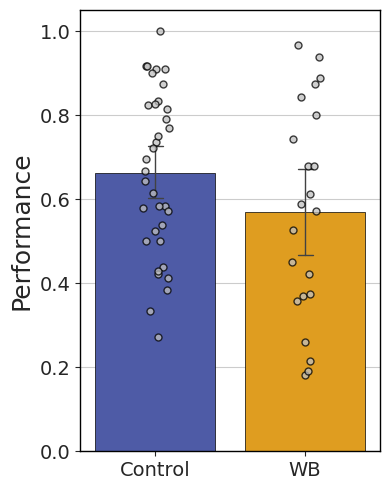

T-test between Control and WB: p-val = 0.184


In [ ]:
var = 'Performance'
fig, ax = plt.subplots(1,1, figsize=(4, 5))
hax = ax
sns.barplot(data=bias_scores_df, ax = hax, x='Treatment', y= var, capsize = 0.1, errwidth = 1, palette = ttxpalette(['Control', 'WB']), edgecolor='k')
sns.stripplot(data=bias_scores_df, ax = hax, x='Treatment', y= var, alpha=0.75, color = '0.75', edgecolor='k', linewidth = 1)
#hax.set_title('History-Dependent Bias Scores by Treatment')
hax.set_xlabel(None)
hax.set_ylabel(f'{var}')

fname = f'{var}.png'
plt.tight_layout()
#plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor=None, backend=None)
plt.show()


# Perform statistical tests to compare treatments
treatments = bias_scores_df['Treatment'].unique()
for i in range(len(treatments)):
    for j in range(i+1, len(treatments)):
        treatment1 = treatments[i]
        treatment2 = treatments[j]
        bias1 = bias_scores_df[bias_scores_df['Treatment'] == treatment1][var]
        bias2 = bias_scores_df[bias_scores_df['Treatment'] == treatment2][var]
        t_stat, p_val = stats.mannwhitneyu(bias1, bias2, nan_policy = 'omit')
        print(f'T-test between {treatment1} and {treatment2}: p-val = {p_val:.3f}')

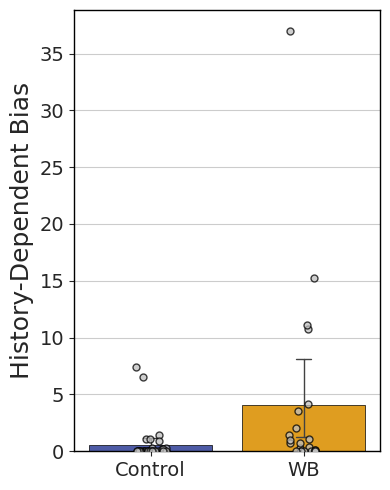

T-test between Control and WB: p-val = 0.002


In [ ]:
# Plot bias scores for each treatment
fig, ax = plt.subplots(1,1, figsize=(4, 5))
hax = ax
sns.barplot(data=bias_scores_df, ax = hax, x='Treatment', y='Bias', capsize = 0.1, errwidth = 1, palette = ttxpalette(['Control', 'WB']), edgecolor='k')
sns.stripplot(data=bias_scores_df, ax = hax, x='Treatment', y='Bias', alpha=0.75, color = '0.75', edgecolor='k', linewidth = 1)
#hax.set_title('History-Dependent Bias Scores by Treatment')
hax.set_xlabel(None)
hax.set_ylabel('History-Dependent Bias')

fname = f'History_Bias.png'
plt.tight_layout()
plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor=None, backend=None)
plt.show()


# Perform statistical tests to compare treatments
treatments = bias_scores_df['Treatment'].unique()
for i in range(len(treatments)):
    for j in range(i+1, len(treatments)):
        treatment1 = treatments[i]
        treatment2 = treatments[j]
        bias1 = bias_scores_df[bias_scores_df['Treatment'] == treatment1]['Bias']
        bias2 = bias_scores_df[bias_scores_df['Treatment'] == treatment2]['Bias']
        t_stat, p_val = stats.mannwhitneyu(bias1, bias2, nan_policy = 'omit')
        print(f'T-test between {treatment1} and {treatment2}: p-val = {p_val:.3f}')



## Performance Analysis

In [ ]:
path = homeFolder + 'FractalTable.csv'
L= pd.read_csv(path)
L.head(3)

,Rec,nTrial,Trial,Epoch,Treatment,Hemisphere,Structure,Speed,Acc,Theta,Beta,Gamma,fTheta,fBeta,fGamma
0,Rec1,1,HIT,Start,Control,L,DLS,18.851702,0.084503,-0.886042,-0.853218,0.569239,5.75,20.0,47.00
1,Rec1,2,HIT,Start,Control,L,DLS,5.385658,0.087147,-0.803077,0.335654,0.908059,4.25,17.5,49.75
2,Rec1,3,HIT,Start,Control,L,DLS,0.180555,0.091434,0.254699,-1.212263,1.390533,6.25,16.5,43.75


In [ ]:
bHemi = np.unique(L.Hemisphere)
bRec = np.unique(L.Rec)
bStructure = ['plPFC', 'OFC', 'DLS', 'NAcCore', 'PPC', 'dHipp', 'MDT']
bEpoch = ['Start', 'Cue', 'Running', 'Reward', 'TimeOut']

rec = []
ttx = []
perf = []
ntrials = []

for rx in range(len(bRec)):
    idx = 0
    dummy = L[(L.Hemisphere == bHemi[0]) &
              (L.Rec == bRec[rx]) &
              (L.Structure == bStructure[idx]) &
              (L.Epoch == bEpoch[0])]

    if len(dummy) == 0:
        while True:
            idx = idx + 1
            if idx >= len(bStructure):
                break

            dummy = L[(L.Hemisphere == bHemi[0]) &
                      (L.Rec == bRec[rx]) &
                      (L.Structure == bStructure[idx]) &
                      (L.Epoch == bEpoch[0])]

            if len(dummy) > 0:
                break

    xresp = np.nansum(dummy.Trial == 'HIT') / len(dummy)
    perf.append(xresp)
    ttx.append(np.unique(dummy.Treatment)[0])  # fix to append the actual treatment value
    rec.append(bRec[rx])
    ntrials.append(np.nansum(len(dummy)))

df = pd.DataFrame({'Rec': rec, 'Treatment': ttx, 'Performance': perf, 'NTrials': ntrials})


In [ ]:
TtxNames = ['Control', 'WB']

In [ ]:
from scipy.optimize import curve_fit

# Define the sigmoid function
def sigmoid(x, a, b, c, d):
    y = c / (1 + np.exp(-a*(x-b))) + d
    return y

df2 = df[(df.Performance > 0.3)]
mask = (df2.Performance > 0.5) & (df2.NTrials < 15)
df2 = df2[~mask];

df2.reset_index(inplace = True, drop = True)
# Define the data to fit
xdata = df2['NTrials']
ydata = df2['Performance']

# Set initial parameter values for the sigmoid function
p0 = [1, np.mean(xdata), 1, np.mean(ydata)]

# Fit the sigmoid function to the data using 'lm' method
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='lm')


### Remove sessions with low performance:

In [ ]:
#Select only the recordings that fit
bStructure = ['plPFC', 'OFC', 'DLS', 'NAcCore', 'PPC', 'dHipp', 'MDT']
dummy = df2[(df2.Performance > 0.5)]
Data = L[np.in1d(L.Rec, dummy.Rec) & np.in1d(L.Structure, bStructure)]
Data.reset_index(inplace = True, drop = True);


In [ ]:
def cohens_d(group1, group2):
    """
    Calculate Cohen's d effect size.

    Parameters:
    - group1 (array-like): Data for group 1.
    - group2 (array-like): Data for group 2.

    Returns:
    - float: Cohen's d effect size.
    """

    # Calculate means
    mean1, mean2 = np.mean(group1), np.mean(group2)

    # Calculate pooled standard deviation
    pooled_std = np.sqrt((np.var(group1) + np.var(group2)) / 2)

    # Calculate Cohen's d
    d = (mean1 - mean2) / pooled_std

    return d


In [ ]:
def sigSymbol(P):
  if P >= 0.05:
    sig = ' '
  else:
    sig = '*'
    if P <= 0.00001:
      sig = '***'
    elif P <= 0.001:
      sig = '**'
  return sig

### Peak Frequency

In [ ]:
def checkNaNs(array):
    sz = np.size(array,0)
    log = [];
    for ix in range(sz):
        log.append(sum(np.isnan(array[ix]))>0)
        #print(sum(np.isnan(array[ix])))
    return np.array(log);

In [ ]:
def plotFreq(Data, bStructure, Trial, band):
    for ix in range(len(bStructure)):
        fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
        structure = bStructure[ix]

        for epoch in Data.Epoch.unique():
            group1 = Data[(Data.Structure == structure) &
                          (Data.Trial == Trial) &
                          (Data.Epoch == epoch) &
                          (Data.Treatment == 'Control')][f'f{band}']

            group2 = Data[(Data.Structure == structure) &
                          (Data.Trial == Trial) &
                          (Data.Epoch == epoch) &
                          (Data.Treatment == 'WB')][f'f{band}']

            t, p = stats.ttest_ind(group1, group2)
            p_str = f"p = {p:.4f}"  # format p-value as string

            # Calculate Cohen's d
            mean_diff = np.mean(group1) - np.mean(group2)
            pooled_std = np.sqrt((np.var(group1) + np.var(group2)) / 2)
            cohens_d = mean_diff / pooled_std

            # Perform Shapiro-Wilk test for normality
            _, normality_p1 = stats.shapiro(group1)
            _, normality_p2 = stats.shapiro(group2)
            is_normal1 = normality_p1 > 0.05
            is_normal2 = normality_p2 > 0.05

            ypos = max(group1.max(), group2.max()) + 0.2  # position text above plot
            xpos = Data.Epoch.unique().tolist().index(epoch)  # x position on plot
            ax.text(xpos, ypos, f"{p_str}\nCohen's d = {cohens_d:.4f}\nNormality: {is_normal1}, {is_normal2}", ha='center', va='bottom', fontsize=8)
            ax.text(xpos, ypos, f"{p_str}\nCohen's d = {cohens_d:.4f}\nNormality: {is_normal1}, {is_normal2}", ha='center', va='bottom', fontsize=8)

        sns.boxplot(data=Data[(Data.Structure == structure) & (Data.Trial == Trial)],
                    y=f'f{band}', x='Epoch', hue='Treatment', ax=ax, palette = 'colorblind')

        ax.set_ylabel(f'{band} Peak Freq [Hz]')
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        ax.set_xlabel('')
        ax.set_title(f'{structure}')

    plt.tight_layout()


In [ ]:
def sort_matrix_by_vector(matrix, vector, order=['Start', 'Cue', 'Running', 'Reward', 'TimeOut'], axis=0):
    order_dict = {value: index for index, value in enumerate(order)}

    if axis == 0:
        sorted_indices = np.argsort([order_dict[value] for value in vector])
        sorted_matrix = matrix[sorted_indices]
        sorted_vector = [vector[i] for i in sorted_indices]
    elif axis == 1:
        sorted_indices = np.argsort([order_dict[value] for value in vector])
        sorted_matrix = matrix[:, sorted_indices]
        sorted_vector = [vector[i] for i in sorted_indices]
    else:
        raise ValueError("Invalid axis value. Must be 0 for rows or 1 for columns.")

    scores_vector = np.zeros(len(vector))
    for ix in range(len(order)):
        scores_vector[vector == order[ix]] = ix

    scores_vector = scores_vector[sorted_indices];
    return sorted_matrix, sorted_indices, scores_vector




In [ ]:
#To get peak power and freq:
def getMax(spg, sel, epoch, band):
    faxis = np.arange(0, 100, 0.5)
    fmask = (faxis >= 0) & (faxis <= 30)
    bf =  faxis[fmask];
    scaler = MinMaxScaler()

    y = spg[np.logical_and(sel, S.Epoch == epoch),:];
    y = y[:, fmask]


    if len(y) > 0:
        orig = y.T
        orig = orig.reshape(-1)

        y = scaler.fit_transform(y.T)
        y = y.reshape(-1)
        peakpower = np.nanmax(orig[(bf >= band[0]) & (bf <= band[1])]);
        bmax = np.nanmax(y[(bf >= band[0]) & (bf <= band[1])])
        idx = np.argwhere(y == bmax)[0][0]
        peakfreq = bf[idx];
        bandpower = np.nanmean(orig[(bf >= band[0]) & (bf <= band[1])])/np.nanmean(orig[(bf >= 3) & (bf <= 30)]);
    else:
        peakfreq = np.nan
        peakpower = np.nan
        bandpower = np.nan

    return peakfreq, peakpower, bandpower

tableString = homeFolder + 'FractalPeaksTable.csv'
rewriteFlag = False

if rewriteFlag == True:
  #Allocate lists:
  f = [];
  p = [];
  relp = []
  bp = [];

  Rec = []
  Ttx = [];
  Epoch = []
  Outcome = [];
  Structure = [];
  Hemisphere = [];
  Trial = []

  #predefined parameters:
  freqLim = [1, 25];
  fsel = (faxis >= freqLim[0]) & (faxis <= freqLim[1])
  ttx = ['Control', 'WB']
  hemi = ['L', 'R']

  xRec = np.unique(S.Rec)
  xStructure = bStructure

  #extract spectra from the main DataFrame
  spg = np.array(S.iloc[:, 0:len(faxis)])
  bInf = np.isinf(spg)
  spg[bInf] = np.nan

  #Collect data:
  for ix in range(len(xRec)):
      for hx in range(2):
          for sx in range(len(xStructure)):
              xNTrial = np.unique(S.nTrial[S.Rec == xRec[ix]]);
              for jx in range(len(xNTrial)):
                  sel = (S.Rec == xRec[ix]) & (S.Hemisphere == hemi[hx]) & (S.Structure == xStructure[sx]) & (S.nTrial == xNTrial[jx])

                  _,PeakTO,_  = getMax(spg, sel, 'TimeOut', [4,9]);

                  for epoch in bEpoch:
                    peakfreq, peakpower, bandpower  = getMax(spg, sel, epoch, [4,9]);
                    f.append(peakfreq)
                    p.append(peakpower)
                    relp.append(peakpower-PeakTO)
                    bp.append(bandpower)

                    Rec.append(xRec[ix])
                    Ttx.append(np.unique(S.Treatment[S.Rec == xRec[ix]])[0])
                    Epoch.append(epoch)
                    Outcome.append(np.unique(np.unique(S.Trial[(S.Rec == xRec[ix]) & (S.nTrial == xNTrial[jx])]))[0])
                    Structure.append(xStructure[sx])
                    Hemisphere.append(hemi[hx])
                    Trial.append(jx)

  #Create a Dataframe with the collected data:
  bdf = pd.DataFrame({'Power': p, 'RelPower': relp, 'Freq': f, 'BandPower': bp,
                      'Rec': Rec, 'Hemi': Hemisphere, 'Ttx': Ttx, 'Epoch': Epoch,
                      'Structure': Structure, 'Outcome': Outcome, 'Trial': Trial});
  bdf.to_csv(tableString, index=False)
  print('Table saved')
else:
  bdf = pd.read_csv(tableString)
  print('Table Loaded')

bdf.head()


Table Loaded


,Power,RelPower,Freq,BandPower,Rec,Hemi,Ttx,Epoch,Structure,Outcome,Trial
0,9.131737,4.487134,7.0,15.773391,Rec10,L,Control,Start,DLS,FAIL,0
1,4.566959,-0.077645,6.5,0.268833,Rec10,L,Control,Cue,DLS,FAIL,0
2,7.463302,2.818698,5.5,26.075815,Rec10,L,Control,Running,DLS,FAIL,0
3,13.427473,8.782870,6.0,-11.582515,Rec10,L,Control,Reward,DLS,FAIL,0
4,4.644604,0.000000,4.5,-26.829612,Rec10,L,Control,TimeOut,DLS,FAIL,0


## Coherence Analysis:

In [ ]:
path = homeFolder + 'CohTable2.csv'
Coherence = pd.read_csv(path)
dummy = df2[(df2.Performance > 0.5)]
C = Coherence[np.in1d(Coherence.Rec, dummy.Rec)]
C.reset_index(drop = True, inplace = True)

ttx = []
recs = np.unique(df2.Rec)
for rx in recs:
  ttx.append(np.unique(df2.Treatment[np.in1d(df2.Rec, rx)])[0])

C['Treatment'] = np.nan
for ix, rx in enumerate(recs):
  C['Treatment'][C.Rec == rx] = ttx[ix]

C.head(3)


,Rec,Hemi,Trial,Str1,Str2,Band,Epoch,Cue,Outcome,Coh,Phase,Cross,Treatment
0,Rec2,L,1,NAcCore,vHipp,Theta,Start,LEFT,FAIL,0.500927,-1.747909,-1.59102324546986-3.46909566735349i,Control
1,Rec2,L,1,NAcCore,vHipp,Beta,Start,LEFT,FAIL,0.336773,0.951136,0.242012361427841-0.0662074234711959i,Control
2,Rec2,L,1,NAcCore,vHipp,Gamma,Start,LEFT,FAIL,0.283795,0.258263,-0.0830821081884055+0.165622128161224i,Control


In [ ]:
from statsmodels.stats import multitest
from scipy.stats import mannwhitneyu

#freq_band = ['Delta', 'Theta', 'Beta', 'Gamma', 'Broad1']
freq_band = ['Theta']

bEpoch = ['Start', 'Cue', 'Running', 'Reward', 'TimeOut']
Outcome = ['HIT', 'FAIL']

#to which value compare coherence against:
thr = 0
metric = 'Coh'

def adjust_pvalues(pvalues):
  return multitest.multipletests(pvalues.flatten(), method='bonferroni')[1].reshape(pvalues.shape)


xvar = []
xmean = []
xstd = []
xvi = []
xtreatment = []
xepoch = []
xoutcome = []
xfrom = []
xto = []
xrec = []

fileName = homeFolder + 'coh_vals.csv'
if os.path.exists(fileName):
  xdf = pd.read_csv(fileName)
else:
  for bfreq in freq_band:
    #for k in range(len(Outcome)):
    for outcome in ['HIT', 'FAIL']:
        for epoch in bEpoch:
          print(f'{epoch}')
          for i, from_val in enumerate(bStructure):
            for j, to_val in enumerate(bStructure):
              #Control
              ttx = 'Control'
              sel = (C.Band == bfreq) & (C.Str1 == from_val) & (C.Str2 == to_val) & (C.Outcome == outcome) & (C.Treatment == ttx)
              grouped1 = C[metric][sel & (C.Epoch == epoch)]
              grpTO = C[metric][sel & (C.Epoch == 'TimeOut')]
              if len(grouped1) == 0:
                  sel = (C.Band == bfreq) & (C.Str1 == to_val) & (C.Str2 == from_val) & (C.Outcome == outcome) & (C.Treatment == ttx)
                  grouped1 = C[metric][sel & (C.Epoch == epoch)]
                  grpTO = C[metric][sel & (C.Epoch == 'TimeOut')]
              grp = np.array(grouped1)
              if len(grp) > 0:
                xrec.extend(C.Rec[sel & (C.Epoch == epoch)])
                xvar.extend(grp)
                print(f'grp is {len(grp)}, and rec {len(C.Rec[sel & (C.Epoch == epoch)])}')
                xfrom.extend(np.repeat(from_val, len(grp)))
                xto.extend(np.repeat(to_val, len(grp)))
                xepoch.extend(np.repeat(epoch, len(grp)))
                xoutcome.extend(np.repeat(outcome, len(grp)))
                xtreatment.extend(np.repeat(ttx, len(grp)))

              #WB
              ttx = 'WB'
              sel = (C.Band == bfreq) & (C.Str1 == from_val) & (C.Str2 == to_val) & (C.Outcome == outcome) & (C.Treatment == ttx)
              grouped1 = C[metric][sel & (C.Epoch == epoch)]
              grpTO = C[metric][sel & (C.Epoch == 'TimeOut')]
              if len(grouped1) == 0:
                  sel = (C.Band == bfreq) & (C.Str1 == to_val) & (C.Str2 == from_val) & (C.Outcome == outcome) & (C.Treatment == ttx)
                  grouped1 = C[metric][sel & (C.Epoch == epoch)]
                  grpTO = C[metric][sel & (C.Epoch == 'TimeOut')]
              grp = np.array(grouped1)
              if len(grp) > 0:
                xrec.extend(C.Rec[sel & (C.Epoch == epoch)])
                xvar.extend(grp)
                print(f'grp is {len(grp)}, and rec {len(C.Rec[sel & (C.Epoch == epoch)])}')
                xfrom.extend(np.repeat(from_val, len(grp)))
                xto.extend(np.repeat(to_val, len(grp)))
                xepoch.extend(np.repeat(epoch, len(grp)))
                xoutcome.extend(np.repeat(outcome, len(grp)))
                xtreatment.extend(np.repeat(ttx, len(grp)))

  xdf = pd.DataFrame({'Coh': xvar, 'Treatment': xtreatment, 'Epoch': xepoch, 'Outcome': xoutcome, 'From': xfrom, 'To': xto, 'Rec': xrec})
  xdf.to_csv(fileName)



In [ ]:
import os
import numpy as np
import pandas as pd
from statsmodels.stats import multitest
from scipy.stats import mannwhitneyu

# Define parameters
freq_band = ['Theta']
bEpoch = ['Start', 'Cue', 'Running', 'Reward', 'TimeOut']
Outcome = ['HIT', 'FAIL']
thr = 0  # Threshold for coherence comparison
metric = 'Coh'

# Adjust p-values with Bonferroni correction
def adjust_pvalues(pvalues):
    return multitest.multipletests(pvalues.flatten(), method='bonferroni')[1].reshape(pvalues.shape)

# Load or create coherence data
rewriteFlag = False

if rewriteFlag == False:
    data = pd.read_csv(homeFolder + 'Coh_Table.csv')
    datav = pd.read_csv(homeFolder + 'CV_Table.csv')
else:
    xvar, xtreatment, xepoch, xoutcome, xrec = [], [], [], [], []
    vvar, vtreatment, vepoch, voutcome, vrec = [], [], [], [], []

    for bfreq in freq_band:
        for outcome in Outcome:
            for epoch in bEpoch:
                print(f'Processing epoch: {epoch}, outcome: {outcome}')
                for rec in np.unique(xdf.Rec):
                    print(f'Recording: {rec}')
                    matrix = np.empty((len(bStructure), len(bStructure)))
                    matrix[:] = np.nan  # Initialize matrix with NaNs

                    # Fill matrix with average coherence values for Control and WB treatments
                    for i, from_val in enumerate(bStructure):
                        for j, to_val in enumerate(bStructure):
                            for treatment in ['Control', 'WB']:
                                sel = (
                                    (xdf.Rec == rec) & (xdf.From == from_val) &
                                    (xdf.To == to_val) & (xdf.Outcome == outcome) &
                                    (xdf.Treatment == treatment) & (xdf.Epoch == epoch)
                                )
                                grouped = xdf[metric][sel]

                                if len(grouped) == 0:
                                    # Swap from_val and to_val if initial selection is empty
                                    sel = (
                                        (xdf.Rec == rec) & (xdf.From == to_val) &
                                        (xdf.To == from_val) & (xdf.Outcome == outcome) &
                                        (xdf.Treatment == treatment) & (xdf.Epoch == epoch)
                                    )
                                    grouped = xdf[metric][sel]

                                # Update matrix values for each treatment
                                if treatment == 'Control':
                                    matrix[i, j] = np.nanmean(grouped)
                                else:
                                    matrix[j, i] = np.nanmean(grouped)

                    # Calculate average coherence values for Control and WB
                    control = [matrix[i, j] for i in range(len(bStructure)) for j in range(i)]
                    wb = [matrix[i, j] for i in range(len(bStructure)) for j in range(i + 1, len(bStructure))]

                    # Append coherence values, metadata, and recording info
                    xvar.extend(control + wb)
                    xtreatment.extend(['Control'] * len(control) + ['WB'] * len(wb))
                    xepoch.extend([epoch] * (len(control) + len(wb)))
                    xoutcome.extend([outcome] * (len(control) + len(wb)))
                    xrec.extend([rec] * (len(control) + len(wb)))

                    # Variability index calculation
                    sum_under_diagonal = [matrix[i, j] for i in range(len(matrix)) for j in range(i)]
                    sum_over_diagonal = [matrix[i, j] for i in range(len(matrix)) for j in range(i + 1, len(matrix))]

                    avg_under = np.nanstd(sum_under_diagonal) / np.nanmean(sum_under_diagonal)
                    avg_over = np.nanstd(sum_over_diagonal) / np.nanmean(sum_over_diagonal)

                    # Append variability index data
                    vvar.extend([avg_under, avg_over])
                    vtreatment.extend(['Control', 'WB'])
                    vepoch.extend([epoch, epoch])
                    voutcome.extend([outcome, outcome])
                    vrec.extend([rec, rec])

    # Save data to DataFrames and CSVs
    data = pd.DataFrame({'Rec': xrec, 'Treatment': xtreatment, 'Epoch': xepoch, 'Outcome': xoutcome, 'Coh': xvar})
    datav = pd.DataFrame({'Rec': vrec, 'Treatment': vtreatment, 'Epoch': vepoch, 'Outcome': voutcome, 'VI': vvar})
    data.to_csv(homeFolder + 'Coh_Table.csv', index=False)
    datav.to_csv(homeFolder + 'CV_Table.csv', index=False)

print("Data processing complete.")


Data processing complete.


In [ ]:
bEpoch = ['Start', 'Cue', 'Running', 'Outcome', 'TimeOut']


GLME Results for Outcome = HIT: CTRL: N = 230 WB: N = 219
                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Coh      
No. Observations:        2245           Method:                    REML     
No. Groups:              26             Scale:                     0.0052   
Min. group size:         45             Log-Likelihood:            2644.1213
Max. group size:         150            Converged:                 Yes      
Mean group size:         86.3                                               
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.388    0.009  43.031 0.000  0.371  0.406
Treatment[T.WB]                  -0.008    0.014  -0.610 0.542 -0.035  0.018
Epoch[T.Cue]                      0.0

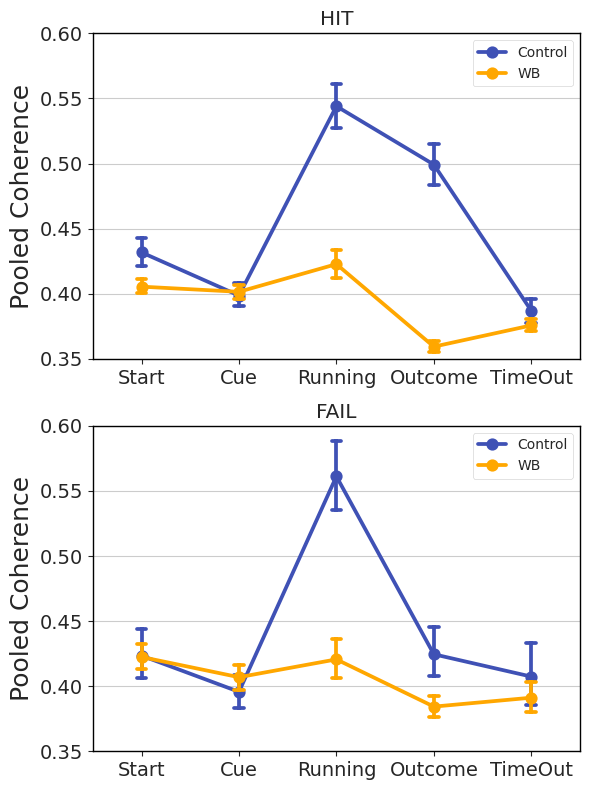

In [ ]:
# Plotting settings
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharey=False)
YLim = [0.35, 0.6]
var = 'Coh'

bdata = C[C.Band == 'Theta'].groupby(['Rec', 'Treatment', 'Outcome', 'Epoch', 'Trial'], as_index=False)['Coh'].mean()
bdata['Epoch'] = pd.Categorical(bdata['Epoch'], categories=['TimeOut'] + [cat for cat in bdata['Epoch'].unique() if cat != 'TimeOut'], ordered=True)
bdata = bdata.dropna(subset=[var])

# Define plotting and GLME/Post-hoc testing loop
for ix, outcome in enumerate(['HIT', 'FAIL']):
    hax = ax[ix]
    sns.pointplot(
        ax=hax, data=bdata[bdata.Outcome == outcome], x='Epoch', y=var, order = bEpoch,
        hue='Treatment', capsize=0.1, palette=ttxpalette(['Control', 'WB'])
    )
    hax.set_ylim(YLim)
    hax.set_title(f'{outcome}')
    hax.set_ylabel('Pooled Coherence', fontsize = 18)
    hax.set_xlabel(None)
    hax.legend()

    # Mixed-effects model formula and fitting
    formula = f'{var} ~ Treatment * Epoch'
    model = smf.mixedlm(formula, data=bdata[bdata.Outcome == outcome], groups=bdata[bdata.Outcome == outcome]['Rec']).fit()
    print(f"GLME Results for Outcome = {outcome}: CTRL: N = {len(bdata[(bdata.Outcome == outcome) & (bdata.Epoch == 'TimeOut') & (bdata.Treatment == 'Control')])} WB: N = {len(bdata[(bdata.Outcome == outcome) & (bdata.Epoch == 'TimeOut') & (bdata.Treatment == 'WB')])}\n", model.summary())

    # Loop through each epoch for non-parametric post-hoc comparisons (Tukey)
    for epoch in ['Start', 'Cue', 'Running', 'Outcome', 'TimeOut']:
        print(f'\nPost-hoc comparisons for {epoch} in Outcome = {outcome}:')
        sel = (bdata.Outcome == outcome) & (bdata.Epoch == epoch)
        if bdata[sel].shape[0] > 0:
            posthoc = pairwise_tukeyhsd(endog=bdata[sel][var], groups=bdata[sel]['Treatment'], alpha=0.01)
            print(posthoc)
        else:
            print(f"No data available for Epoch: {epoch}")

    print('\n')

# Saving the plot
fname = 'Coh_PooledAvg.png'
plt.tight_layout()
plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor=None, backend=None)
plt.show()

GLME Results for Outcome = HIT:
                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        VI      
No. Observations:        130            Method:                    REML    
No. Groups:              26             Scale:                     0.0017  
Min. group size:         5              Log-Likelihood:            177.6024
Max. group size:         5              Converged:                 Yes     
Mean group size:         5.0                                               
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.220    0.015 14.473 0.000  0.190  0.250
Treatment[T.WB]                  -0.011    0.023 -0.473 0.636 -0.057  0.035
Epoch[T.Start]                   -0.026    0.015 -1.755 0.079 -0.056  0.00

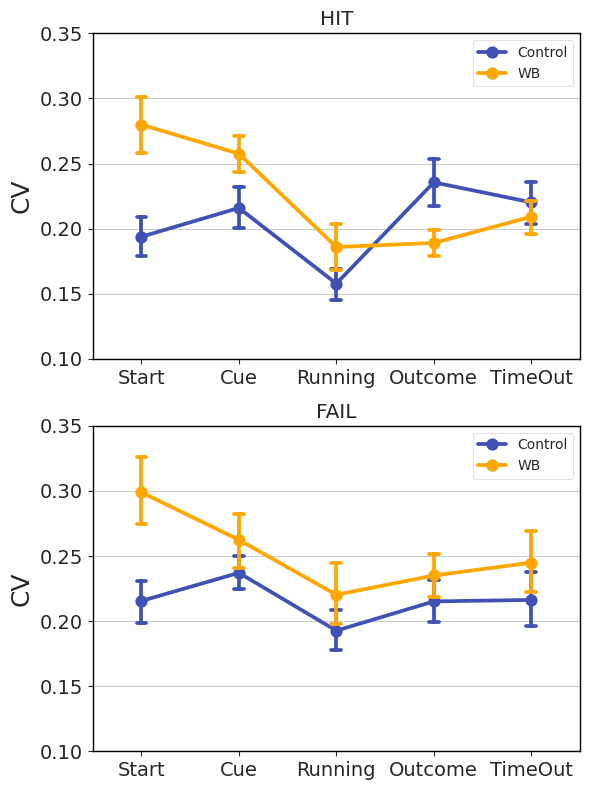

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting settings
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharey=False)

YLim = [0.10, 0.35]
var = 'VI'
bdata = datav.dropna(subset=[var])
bdata['Epoch'] = bdata['Epoch'].replace({'Reward': 'Outcome'})  # Replace Reward with Outcome
bdata['Epoch'] = pd.Categorical(bdata['Epoch'], categories=['TimeOut'] + [cat for cat in bdata['Epoch'].unique() if cat != 'TimeOut'], ordered=True)

# Define plotting and GLME/Post-hoc testing loop
for ix, outcome in enumerate(['HIT', 'FAIL']):
    hax = ax[ix]
    sns.pointplot(
        ax=hax, data=bdata[bdata.Outcome == outcome], x='Epoch', y=var, order = bEpoch, hue='Treatment',
        capsize=0.1, ci=68, palette=ttxpalette(['Control', 'WB'])
    )
    hax.set_ylim(YLim)
    hax.set_title(f'{outcome}')
    hax.set_ylabel('CV', fontsize = 18)
    hax.set_xlabel(None)
    hax.legend()

    # Mixed-effects model formula and fitting
    formula = f'{var} ~ Treatment * Epoch'
    model = smf.mixedlm(formula, data=bdata[bdata.Outcome == outcome], groups=bdata[bdata.Outcome == outcome]['Rec']).fit()
    print(f"GLME Results for Outcome = {outcome}:\n", model.summary())

    # Loop through each epoch for non-parametric post-hoc comparisons (Tukey)
    for epoch in ['Start', 'Cue', 'Running', 'Outcome', 'TimeOut']:
        print(f'\nPost-hoc comparisons for {epoch} in Outcome = {outcome}:')
        sel = (bdata.Outcome == outcome) & (bdata.Epoch == epoch)
        if bdata[sel].shape[0] > 0:
            posthoc = pairwise_tukeyhsd(
                endog=bdata[sel][var], groups=bdata[sel]['Treatment'], alpha=0.05
            )
            print(posthoc)
        else:
            print(f"No data available for Epoch: {epoch}")

    print('\n')

# Saving the plot
fname = 'VI_PooledAvg.png'
plt.tight_layout()
plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor=None, backend=None)
plt.show()


In [ ]:
C.Str1[C.Str1 == 'NAcCore'] = 'nAc'
C.Str2[C.Str2 == 'NAcCore'] = 'nAc'
C.Epoch[C.Epoch == 'Reward'] = 'Outcome'

Control: 49
WB: 49
Control: 49
WB: 49
Control: 49
WB: 49
Control: 49
WB: 49
Control: 49
WB: 49


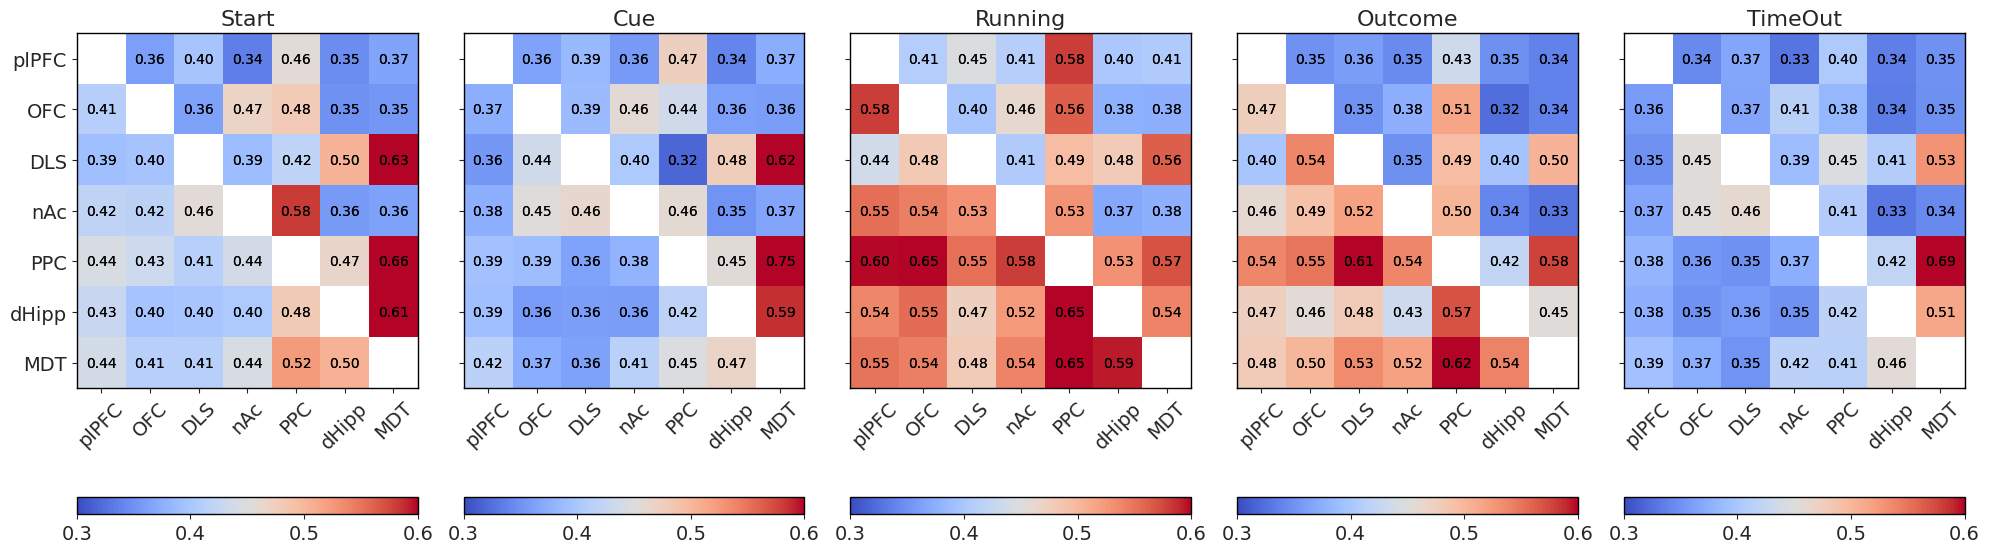

Control: 49
WB: 49
Control: 49
WB: 49
Control: 49
WB: 49
Control: 49
WB: 49
Control: 49
WB: 49


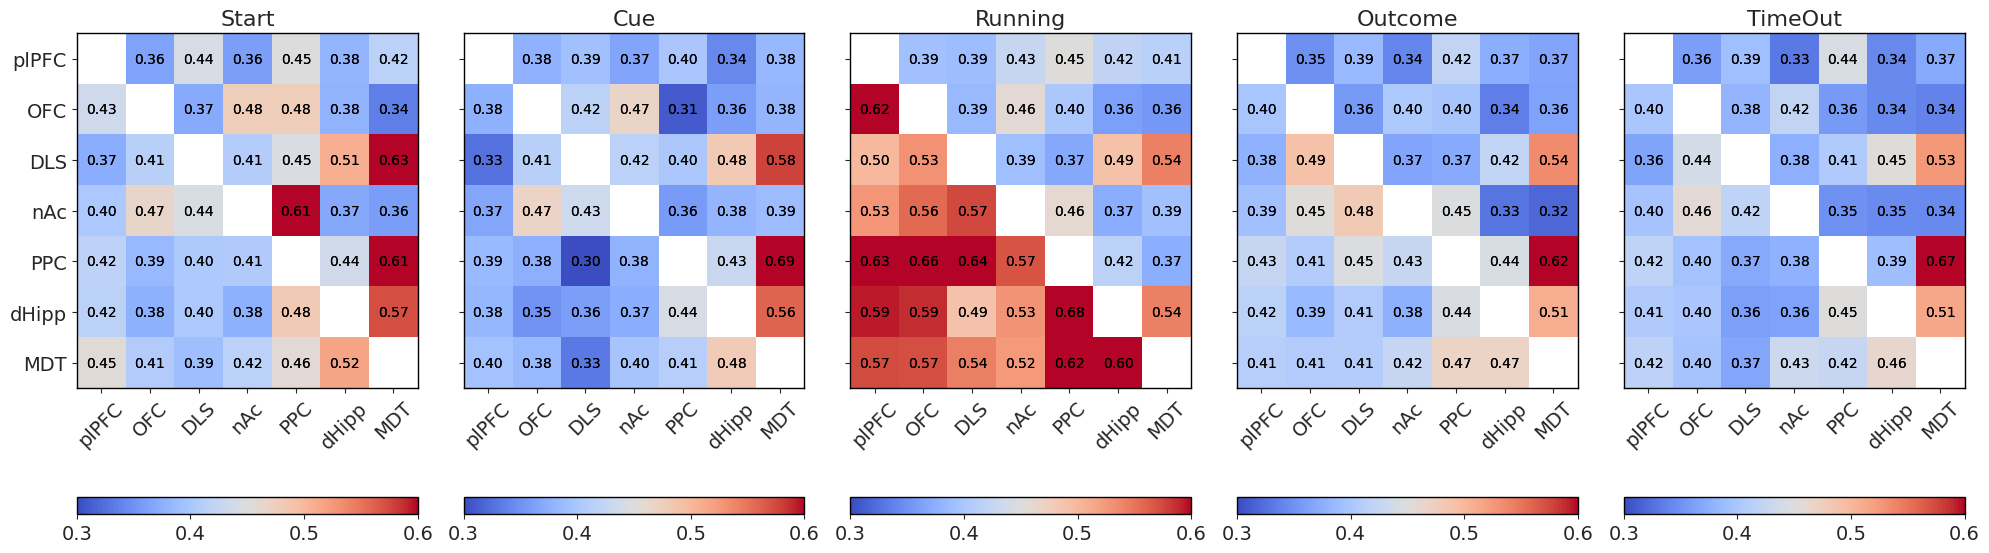

In [ ]:
from statsmodels.stats import multitest
from scipy.stats import mannwhitneyu

#freq_band = ['Delta', 'Theta', 'Beta', 'Gamma', 'Broad1']
freq_band = ['Theta']

bEpoch = ['Start', 'Cue', 'Running', 'Outcome', 'TimeOut']
Outcome = ['HIT', 'FAIL']

#to which value compare coherence against:
thr = 0
metric = 'Coh'


bStructure = ['plPFC', 'OFC', 'DLS', 'nAc', 'PPC', 'dHipp', 'MDT']

def adjust_pvalues(pvalues):
  return multitest.multipletests(pvalues.flatten(), method='bonferroni')[1].reshape(pvalues.shape)


xvar = []
xmean = []
xstd = []
xvi = []
xtreatment = []
xepoch = []
xoutcome = []

for bfreq in freq_band:
  for k in range(len(Outcome)):

      fig, ax = plt.subplots(1,len(bEpoch), figsize=(20, 6), sharey=True)
      for ix in range(len(bEpoch)):
          epoch = bEpoch[ix]
          matrix = np.empty((len(bStructure), len(bStructure)))
          matrix[:] = np.nan
          pvalues = np.empty_like(matrix)

          control = []
          wb = []
          for i, from_val in enumerate(bStructure):
              for j, to_val in enumerate(bStructure):

                  #Control
                  grouped1 = C[metric][(C.Band == bfreq) & (C.Str1 == from_val) & (C.Str2 == to_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'Control') & (C.Epoch == epoch)]
                  grpTO = C[metric][(C.Band == bfreq) & (C.Str1 == from_val) & (C.Str2 == to_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'Control') & (C.Epoch == 'TimeOut')]
                  if len(grouped1) == 0:
                      grouped1 = C[metric][(C.Band == bfreq) & (C.Str1 == to_val) & (C.Str2 == from_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'Control') & (C.Epoch == epoch)]
                      grpTO = C[metric][(C.Band == bfreq) & (C.Str1 == to_val) & (C.Str2 == from_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'Control') & (C.Epoch == 'TimeOut')]
                  grp = np.array(grouped1)
                  matrix[i, j] = np.nanmean(grp)
                  thr = np.percentile(C.Coh[C.Treatment == 'Control'], 0.01)
                  #_, pvalue = stats.ttest_1samp(grp, popmean=thr, nan_policy = 'omit', alternative = 'greater')
                  if len(grp) == 0:
                    pvalue = np.nan
                  else:
                    stat, pvalue = mannwhitneyu(grp, grpTO)

                  pvalues[i, j] = pvalue*len(grp)
                  #print(f'Control: {len(grp)}')
                  control.append(np.nanmean(grp))


                  #WB
                  grouped2 = C[metric][(C.Band == bfreq) & (C.Str1 == from_val) & (C.Str2 == to_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'WB') & (C.Epoch == epoch)]
                  grpTO = C[metric][(C.Band == bfreq) & (C.Str1 == from_val) & (C.Str2 == to_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'WB') & (C.Epoch == 'TimeOut')]
                  if len(grouped2) == 0:
                      grouped2 = C[metric][(C.Band == bfreq) & (C.Str1 == to_val) & (C.Str2 == from_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'WB') & (C.Epoch == epoch)]
                      grpTO = C[metric][(C.Band == bfreq) & (C.Str1 == to_val) & (C.Str2 == from_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'WB') & (C.Epoch == 'TimeOut')]
                  grp = np.array(grouped2)
                  matrix[j, i] = np.nanmean(grp)
                  thr = np.percentile(C.Coh[C.Treatment == 'WB'], 0.01)
                  #_, pvalue = stats.ttest_1samp(grp, popmean=thr, nan_policy = 'omit', alternative = 'greater')
                  if len(grp) == 0:
                    pvalue = np.nan
                  else:
                    stat, pvalue = mannwhitneyu(grp, grpTO)

                  pvalues[j, i] = pvalue*len(grp)
                  #print(f'WB: {len(grp)}')
                  wb.append(np.nanmean(grp))

          print(f'Control: {len(control)}')
          print(f'WB: {len(wb)}')
          pvalues = adjust_pvalues(pvalues)

          xtreatment.extend(np.repeat('Control', len(control)))
          xvar.extend(control)
          xepoch.extend(np.repeat(epoch, len(control)))
          xoutcome.extend(np.repeat(Outcome[k], len(control)))

          xtreatment.extend(np.repeat('WB', len(wb)))
          xvar.extend(wb)
          xepoch.extend(np.repeat(epoch, len(wb)))
          xoutcome.extend(np.repeat(Outcome[k], len(wb)))


          # Flip the matrix horizontally
          flipped_matrix = np.fliplr(matrix)

          # 1. Diagonal Extraction
          diagonal = np.diag(flipped_matrix)

          # 2. Upper Triangle (Originally Under Diagonal)
          upper_triangle = np.triu(flipped_matrix, k=1)
          original_lower_avg = np.nanstd(upper_triangle[upper_triangle != 0])/np.nanmean(upper_triangle[upper_triangle != 0])

          # 3. Lower Triangle (Originally Over Diagonal)
          lower_triangle = np.tril(flipped_matrix, k=-1)
          original_upper_avg = np.nanstd(lower_triangle[lower_triangle != 0])/np.nanmean(lower_triangle[lower_triangle != 0])
          xvi.append((original_lower_avg, original_upper_avg, epoch, Outcome[k]))

          #im = ax[ix].imshow(matrix, cmap='coolwarm', vmin=0.4, vmax=0.6)
          im = ax[ix].imshow(matrix, cmap='coolwarm', vmin=0.3, vmax=0.6, aspect = 'auto')

          #im = ax[ix].imshow(matrix, cmap='coolwarm', aspect = 'auto')
          ax[ix].set_xticks(np.arange(len(bStructure)))
          ax[ix].set_yticks(np.arange(len(bStructure)))
          ax[ix].set_xticklabels(bStructure, rotation=45, fontsize = 14)
          ax[ix].set_yticklabels(bStructure, fontsize = 14)
          #ax[ix].set_xlabel('From')
          #ax[ix].set_ylabel('To')
          ax[ix].grid(False)
          cbar = ax[ix].figure.colorbar(im, ax=ax[ix], orientation="horizontal", pad = 0.2)
          #cbar.ax.set_ylabel(freq_band[fx], rotation=-90, va="bottom")

          alpha = 0.01
          for i in range(len(bStructure)):
              for j in range(len(bStructure)):
                pairs = [[i,j], [j,i]]
                for bpair in pairs:
                  if np.isnan(matrix[bpair[0], bpair[1]]) == False:
                      if pvalues[bpair[0], bpair[1]] < alpha:
                        if matrix[bpair[0], bpair[1]]>thr:
                          text = ax[ix].text(bpair[1], bpair[0], f'{matrix[bpair[0], bpair[1]]:.2f}', ha='center', va='center', color='k', fontsize=10)
                          #text = ax[ix].text(bpair[1], bpair[0], '\n\n*', ha='center', va='center', color='k', fontsize=10)
                        else:
                          text = ax[ix].text(bpair[1], bpair[0], f'{matrix[bpair[0], bpair[1]]:.2f}', ha='center', va='center', color='k', fontsize=10)
                      else:
                          text = ax[ix].text(bpair[1], bpair[0], f'{matrix[bpair[0], bpair[1]]:.2f}', ha='center', va='center', color='k', fontsize=10)

          #ax[ix].set_title(f'{bfreq} - {epoch} - {Outcome[k]}')
          ax[ix].set_title(f'{epoch}', fontsize = 16)

      fname = f'Coh{bfreq}_{Outcome[k]}_{metric}.png'
      plt.tight_layout()
      plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor=None, backend=None)
      plt.show()


In [ ]:
from statsmodels.stats import multitest
from scipy.stats import mannwhitneyu

#freq_band = ['Delta', 'Theta', 'Beta', 'Gamma', 'Broad1']
freq_band = ['Theta']

bEpoch = ['Start', 'Cue', 'Running', 'Outcome', 'TimeOut']
Outcome = ['HIT', 'FAIL']

#to which value compare coherence against:
thr = 0
metric = 'Coh'

bStructure = ['plPFC', 'OFC', 'DLS', 'nAc', 'PPC', 'dHipp', 'MDT']

def adjust_pvalues(pvalues):
  return multitest.multipletests(pvalues.flatten(), method='bonferroni')[1].reshape(pvalues.shape)


xvar = []
xmean = []
xstd = []
xvi = []
xtreatment = []
xepoch = []
xoutcome = []

for bfreq in freq_band:
  for k in range(len(Outcome)):

      fig, ax = plt.subplots(1,len(bEpoch), figsize=(20, 6), sharey=True)
      for ix in range(len(bEpoch)):
          epoch = bEpoch[ix]
          matrix = np.empty((len(bStructure), len(bStructure)))
          matrix[:] = np.nan
          pvalues = np.empty_like(matrix)
          print(f'\n{epoch}:')

          for structure in bStructure:
            for ttx in ['Control', 'WB']:
              filtered_df = C[(C.Band == bfreq) &
                              (C.Outcome == Outcome[k]) &
                              (C.Treatment == f'{ttx}') &
                              (C.Epoch == epoch) &
                              (C.Str1 == structure) &
                              (C.Str2 != structure)]
              if len(filtered_df) == 0:
                continue

              # Create unique pairs of Str1 and Str2 for the specific structure
              selFirst = filtered_df.Str2.unique()
              dummy = filtered_df[(filtered_df.Str1 == structure) &
                              (filtered_df.Str2 == selFirst[0])]

              print(f'- {ttx} {structure}: N = {len(dummy)}')

          control = []
          wb = []
          for i, from_val in enumerate(bStructure):
              for j, to_val in enumerate(bStructure):

                  #Control
                  grouped1 = C[metric][(C.Band == bfreq) & (C.Str1 == from_val) & (C.Str2 == to_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'Control') & (C.Epoch == epoch)]
                  grpTO = C[metric][(C.Band == bfreq) & (C.Str1 == from_val) & (C.Str2 == to_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'Control') & (C.Epoch == 'TimeOut')]
                  if len(grouped1) == 0:
                      grouped1 = C[metric][(C.Band == bfreq) & (C.Str1 == to_val) & (C.Str2 == from_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'Control') & (C.Epoch == epoch)]
                      grpTO = C[metric][(C.Band == bfreq) & (C.Str1 == to_val) & (C.Str2 == from_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'Control') & (C.Epoch == 'TimeOut')]
                  grp = np.array(grouped1)
                  matrix[i, j] = np.nanmean(grp)
                  thr = np.percentile(C.Coh[C.Treatment == 'Control'], 0.01)
                  #_, pvalue = stats.ttest_1samp(grp, popmean=thr, nan_policy = 'omit', alternative = 'greater')
                  if len(grp) == 0:
                    pvalue = np.nan
                  else:
                    stat, pvalue = mannwhitneyu(grp, grpTO)

                  pvalues[i, j] = pvalue*len(grp)
                  #print(f'Control: {len(grp)}')
                  control.append(np.nanmean(grp))


                  #WB
                  grouped2 = C[metric][(C.Band == bfreq) & (C.Str1 == from_val) & (C.Str2 == to_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'WB') & (C.Epoch == epoch)]
                  grpTO = C[metric][(C.Band == bfreq) & (C.Str1 == from_val) & (C.Str2 == to_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'WB') & (C.Epoch == 'TimeOut')]
                  if len(grouped2) == 0:
                      grouped2 = C[metric][(C.Band == bfreq) & (C.Str1 == to_val) & (C.Str2 == from_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'WB') & (C.Epoch == epoch)]
                      grpTO = C[metric][(C.Band == bfreq) & (C.Str1 == to_val) & (C.Str2 == from_val) & (C.Outcome == Outcome[k]) & (C.Treatment == 'WB') & (C.Epoch == 'TimeOut')]
                  grp = np.array(grouped2)
                  matrix[j, i] = np.nanmean(grp)
                  thr = np.percentile(C.Coh[C.Treatment == 'WB'], 0.01)
                  #_, pvalue = stats.ttest_1samp(grp, popmean=thr, nan_policy = 'omit', alternative = 'greater')
                  if len(grp) == 0:
                    pvalue = np.nan
                  else:
                    stat, pvalue = mannwhitneyu(grp, grpTO)

                  pvalues[j, i] = pvalue*len(grp)
                  #print(f'WB: {len(grp)}')
                  wb.append(np.nanmean(grp))


          pvalues = adjust_pvalues(pvalues)

          xtreatment.extend(np.repeat('Control', len(control)))
          xvar.extend(control)
          xepoch.extend(np.repeat(epoch, len(control)))
          xoutcome.extend(np.repeat(Outcome[k], len(control)))

          xtreatment.extend(np.repeat('WB', len(wb)))
          xvar.extend(wb)
          xepoch.extend(np.repeat(epoch, len(wb)))
          xoutcome.extend(np.repeat(Outcome[k], len(wb)))


          # Flip the matrix horizontally
          flipped_matrix = np.fliplr(pvalues)

          # 1. Diagonal Extraction
          diagonal = np.diag(flipped_matrix)

          # 2. Upper Triangle (Originally Under Diagonal)
          upper_triangle = np.triu(flipped_matrix, k=1)
          original_lower_avg = np.nanstd(upper_triangle[upper_triangle != 0])/np.nanmean(upper_triangle[upper_triangle != 0])

          # 3. Lower Triangle (Originally Over Diagonal)
          lower_triangle = np.tril(flipped_matrix, k=-1)
          original_upper_avg = np.nanstd(lower_triangle[lower_triangle != 0])/np.nanmean(lower_triangle[lower_triangle != 0])
          xvi.append((original_lower_avg, original_upper_avg, epoch, Outcome[k]))

          #im = ax[ix].imshow(matrix, cmap='coolwarm', vmin=0.4, vmax=0.6)
          im = ax[ix].imshow(pvalues, cmap='coolwarm', vmin=0.0001, vmax=0.005, aspect = 'auto')

          #im = ax[ix].imshow(matrix, cmap='coolwarm', aspect = 'auto')
          ax[ix].set_xticks(np.arange(len(bStructure)))
          ax[ix].set_yticks(np.arange(len(bStructure)))
          ax[ix].set_xticklabels(bStructure, rotation=45, fontsize = 14)
          ax[ix].set_yticklabels(bStructure, fontsize = 14)
          #ax[ix].set_xlabel('From')
          #ax[ix].set_ylabel('To')
          ax[ix].grid(False)
          cbar = ax[ix].figure.colorbar(im, ax=ax[ix], orientation="horizontal", pad = 0.2)
          #cbar.ax.set_ylabel(freq_band[fx], rotation=-90, va="bottom")

          alpha = 0.01
          for i in range(len(bStructure)):
              for j in range(len(bStructure)):
                pairs = [[i,j], [j,i]]
                for bpair in pairs:
                  if np.isnan(matrix[bpair[0], bpair[1]]) == False:
                      if pvalues[bpair[0], bpair[1]] < alpha:
                        if matrix[bpair[0], bpair[1]]>thr:
                          text = ax[ix].text(bpair[1], bpair[0], f'{pvalues[bpair[0], bpair[1]]:.2e}', ha='center', va='center', color='k', fontsize=5)
                          text = ax[ix].text(bpair[1], bpair[0], '\n\n*', ha='center', va='center', color='k', fontsize=10)
                        else:
                          text = ax[ix].text(bpair[1], bpair[0], f'{pvalues[bpair[0], bpair[1]]:.2e}', ha='center', va='center', color='k', fontsize=5)
                      else:
                          text = ax[ix].text(bpair[1], bpair[0], f'{pvalues[bpair[0], bpair[1]]:.2e}', ha='center', va='center', color='k', fontsize=5)

          #ax[ix].set_title(f'{bfreq} - {epoch} - {Outcome[k]}')
          ax[ix].set_title(f'{epoch}', fontsize = 16)

      fname = f'Coh{bfreq}_{Outcome[k]}_{metric}_pvalues.png'
      plt.tight_layout()
      plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor=None, backend=None)
      plt.show()


## Statistics here:

In [ ]:
bEpoch = ['Start', 'Cue', 'Running', 'Outcome', 'TimeOut']

In [ ]:
data.head()

In [ ]:
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Define the plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
YLim = [0.35, 0.6]
bEpoch = ['Start', 'Cue', 'Running', 'Outcome', 'TimeOut']  # Ensure bEpoch is defined as needed

# Loop over Outcomes (HIT and FAIL) and plot
for i, outcome in enumerate(['HIT', 'FAIL']):
    hax = ax[i]
    for ttx in ['Control', 'WB']:
        pivot = pd.pivot_table(
            data[(data.Outcome == outcome) & (data.Treatment == ttx)],
            values=['Mean', 'SEM'], columns=['Epoch']
        )
        pivot = pivot.reindex(columns=bEpoch)
        hax.errorbar(bEpoch, pivot.values[0], yerr=pivot.values[1], fmt='o-', capsize=3, label=ttx)

    hax.set_ylim(YLim)
    hax.set_title(outcome)
    hax.set_ylabel('Coherence')
    hax.legend()

# Mixed-effects model and post-hoc test
for outcome in ['HIT', 'FAIL']:
    print(f"\nGLME for Outcome: {outcome}")
    subset_data = data[data['Outcome'] == outcome]
    model = smf.mixedlm("Mean ~ Treatment * Epoch", data=subset_data, groups=subset_data['Outcome']).fit()
    print(model.summary())

    # Post-hoc Tukey's HSD for each Epoch
    for epoch in bEpoch:
        print(f"\nPost-hoc comparisons for {epoch} in Outcome = {outcome}:")
        epoch_data = subset_data[subset_data['Epoch'] == epoch]
        if epoch_data.shape[0] > 0:
            posthoc = pairwise_tukeyhsd(endog=epoch_data['Mean'], groups=epoch_data['Treatment'], alpha=0.05)
            print(posthoc)
        else:
            print(f"No data available for Epoch: {epoch}")

plt.tight_layout()
plt.show()


In [ ]:
fig,ax = plt.subplots(1,2,figsize = (10,4), sharey = False)
YLim = [0.35, 0.6]

hax = ax[0]
for ttx in ['Control', 'WB']:
  pivot = pd.pivot_table(data[(data.Outcome == 'HIT') & (data.Treatment == ttx)], values= ['Mean', 'SEM'], columns=['Epoch'])
  pivot = pivot.reindex(columns=bEpoch)
  hax.errorbar(bEpoch, pivot.values[0], yerr = pivot.values[1], fmt = 'o-', capsize = 3, label = ttx)
hax.set_ylim(YLim)
hax.set_title('HIT')
hax.set_ylabel('Coherence')
hax.legend()

hax = ax[1]
for ttx in ['Control', 'WB']:
  pivot = pd.pivot_table(data[(data.Outcome == 'FAIL') & (data.Treatment == ttx)], values= ['Mean', 'SEM'], columns=['Epoch'])
  pivot = pivot.reindex(columns=bEpoch)
  hax.errorbar(bEpoch, pivot.values[0], yerr = pivot.values[1], fmt = 'o-', capsize = 3, label = ttx)

hax.set_ylim(YLim)
hax.set_title('FAIL')
hax.set_ylabel('Coherence')
hax.legend()

fname = f'Coh_PooledAvg.png'
plt.tight_layout()
#plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor=None, backend=None)
plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (10,4), sharey = False)
YLim = [0.07, 0.25]

hax = ax[0]
for ttx in ['Control', 'WB']:
  pivot = pd.pivot_table(data[(data.Outcome == 'HIT') & (data.Treatment == ttx)], values= ['VI'], columns=['Epoch'])
  pivot = pivot.reindex(columns=bEpoch)
  hax.plot(bEpoch, pivot.values[0], 'o-', label = ttx)
hax.set_ylim(YLim)
hax.set_title('HIT')
hax.set_ylabel('Variation Index')
hax.legend()

hax = ax[1]
for ttx in ['Control', 'WB']:
  pivot = pd.pivot_table(data[(data.Outcome == 'FAIL') & (data.Treatment == ttx)], values= ['VI'], columns=['Epoch'])
  pivot = pivot.reindex(columns=bEpoch)
  hax.plot(bEpoch, pivot.values[0], 'o-', label = ttx)

hax.set_ylim(YLim)
hax.set_title('FAIL')
hax.set_ylabel('Variation Index')
hax.legend()

fname = f'Coh_PooledVI.png'
plt.tight_layout()
plt.savefig(picFolder + fname, dpi=200, format=None, metadata=None, bbox_inches=None, pad_inches=0.1, facecolor='white', edgecolor=None, backend=None)
plt.show()

In [ ]:
xcoh = []
xepoch = []
xttx = []
xoutcome = []
xvi = []
for rec in np.unique(C.Rec):
  for ttx in ['Control', 'WB']:
    for outcome in ['HIT', 'FAIL']:
      pivot = pd.pivot_table(C[(C.Outcome == outcome) & (C.Treatment == ttx) & (C.Rec == rec)], values= ['Coh'], columns=['Epoch'])
      xcoh.extend(pivot.values[0])
      xepoch.extend(np.array(pivot.columns))
      xttx.extend(np.repeat(ttx, pivot.shape[1]))
      xoutcome.extend(np.repeat(outcome, pivot.shape[1]))

      bstd = pd.pivot_table(C[(C.Outcome == outcome) & (C.Treatment == ttx) & (C.Rec == rec)], values= ['Coh'], columns=['Epoch'], aggfunc='std')
      bmean = pd.pivot_table(C[(C.Outcome == outcome) & (C.Treatment == ttx) & (C.Rec == rec)], values= ['Coh'], columns=['Epoch'], aggfunc='mean')
      xvi.extend(bstd.values[0]/bmean.values[0])


data2 = pd.DataFrame({'Treatment': xttx, 'Epoch': xepoch, 'Outcome': xoutcome,'Coh':xcoh, 'VI':xvi})
data2.head()
